In [1]:
import os
import sys
import copy
import json
import time
import shutil
import time

import torch
from torch.autograd import Variable
from torch import optim
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# TODO: Fix sibling directory imports
cwd = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(cwd, '.'))

from src.datautils.sandia import SandiaDataProvider
from src.utils import show_batch_of_images
from src.models import mlp_net as mlp
from src.reasoning_agents import FFNReasoningAgent, RNN_RA
from src.classifiers import PairwiseClassifier
from src.utils import show_batch_of_images, dict_of_lists_to_list_of_dicts
from src.ra_training import train_reasoning_agent, train_iteration
from src.autoencoders import Conv2DAutoencoder, PCAAutoencoder, FeedforwardAutoencoder
from src.utiq import UTIQ

import src
from src import train_test, e2e_training
import importlib
importlib.reload(src.utils)
importlib.reload(src.train_test);
importlib.reload(src.e2e_training);
from src.train_test import train, test
from src.e2e_training import train_e2e

# Run from root

In [2]:
%cd ../src

/home/miro/AI/mlp2/mlp-03/src


# Load data

In [ ]:
import src
import importlib
importlib.reload(src.utils)
importlib.reload(src.train_test)
from src.utils import show_matrix
from src.utils import make_vars
from src.utils import show_grid_of_images

train_data = SandiaDataProvider(which_set='train',
                                  dataset_home='../datasets/sandia/',
                                  img_size=28)
val_data = SandiaDataProvider(which_set='valid',
                                  dataset_home='../datasets/sandia/',
                                  img_size=28,
                                  normalize_mean=train_data.normalize_mean,
                                  normalize_sd=train_data.normalize_sd)
test_data = SandiaDataProvider(which_set='test',
                                  dataset_home='../datasets/sandia/',
                                  img_size=28,
                                  normalize_mean=train_data.normalize_mean,
                                  normalize_sd=train_data.normalize_sd)

In [3]:
hyperparams = {
    'img_size': [28],
    'encoding_size': [50, 100, 200, 300],

    'ae_type': ['ff'],
    'ae_hidden_sizes': [[400], [400, 300], [300, 200], [200, 100]],

    'ra_type': ['ff'],
    'ra_hidden_size': [50, 100, 200],
    'ra_num_layers': [1, 2],
    'ra_nonlinearity': ['relu'],
    'ra_network_type': ['vanilla'],

    'clf_type': ['pw'],
    'clf_hidden_sizes': [[100], [200, 100], [50], [100, 50], [50, 30], [80, 50, 10]],
    'clf_nonlinearity': ['relu'],

    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'momentum': [0.1, 0.5, 0.9],
    'weight_decay': [0, 0.05],
    'num_epochs': [80],
    'epoch_patience': [15],
    'batch_size': [8, 16, 32, 64]
}

hyperparams = dict_of_lists_to_list_of_dicts(hyperparams)

In [21]:
hyperparams = {
    'img_size': [28],
    'encoding_size': [50],

    'ae_type': ['ff'],
    'ae_hidden_sizes': [[400]],
    'ae_pretrain': [False],
    'ae_freeze': [False],

    'ra_type': ['ff'],
    'ra_hidden_size': [100],
    'ra_num_layers': [2],
    'ra_nonlinearity': ['relu'],
    'ra_network_type': ['vanilla'],
    'ra_use_batchnorm': [False],

    'clf_type': ['lse'],
    'clf_hidden_sizes': [[80, 40], [100]],
    'clf_nonlinearity': ['relu'],
    'clf_use_batchnorm': [False],
    
    'learning_rate': [0.05],
    'momentum': [0.5],
    'weight_decay': [0.05],
    'num_epochs': [50],
    'epoch_patience': [10],
    'batch_size': [64]
}

hyperparams = dict_of_lists_to_list_of_dicts(hyperparams)

1 out of 2:
24.7 sec
Training stopped after 46 epochs.
Best train acc: 0.198
Best val acc: 0.238 at epoch 34
 Best acc so far: 0.238
2 out of 2:
20.1 sec
Training stopped after 32 epochs.
Best train acc: 0.259
Best val acc: 0.321 at epoch 20
 Best acc so far: 0.321


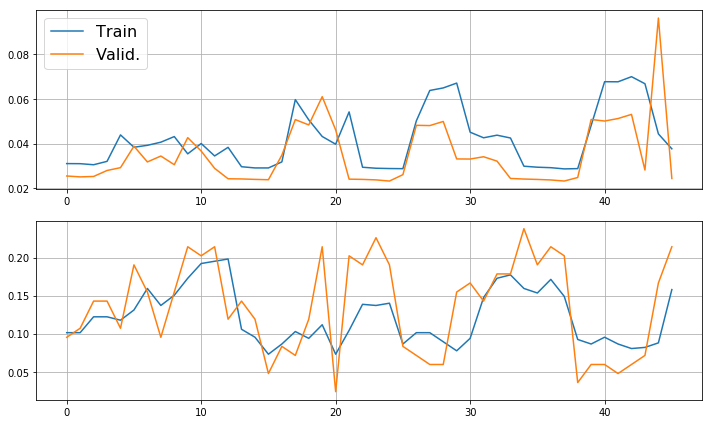

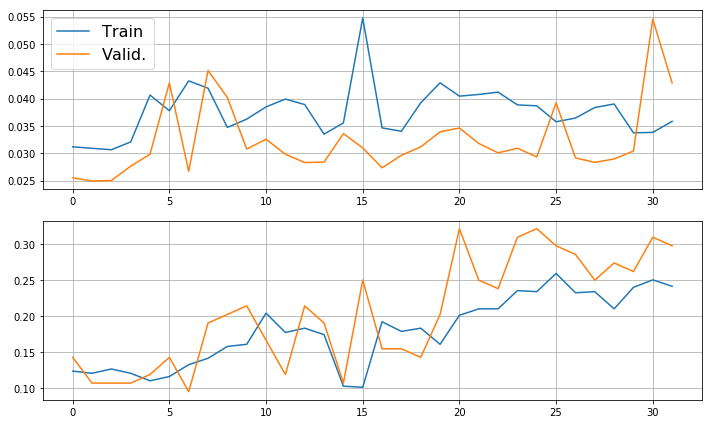

In [34]:
# %debug
use_cuda = False
plot = True
count = 0
all_res = []
for res in train_e2e(hyperparams, use_cuda=use_cuda, verbose=True, plot=plot):
    all_res.append(res)
    pass



In [82]:
# model_number = 0
use_val_data = True
models_used = all_res
images_per_model = 3 # -1 to use batch_size
folder = "../out/exp/images/"
if not os.path.exists(folder):
        os.makedirs(folder)
        

0


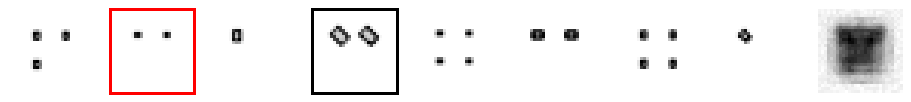

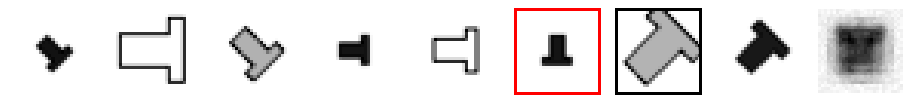

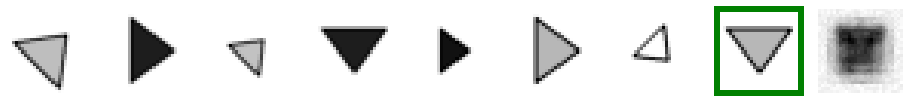

1


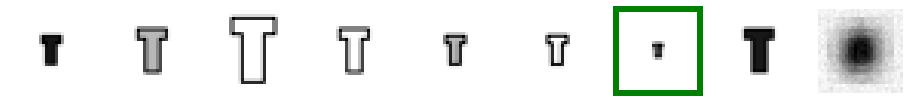

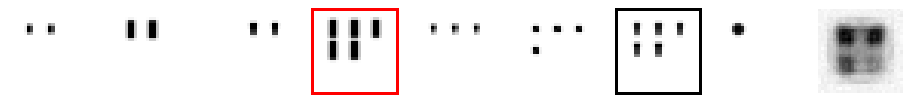

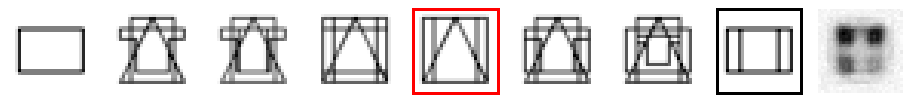

In [90]:

#############################################
for res in models_used:
    model_num = len(os.listdir(folder))
    print(model_num)
    model = res[1] 

    #TODO get from model
    val_batch_size = model_info.get('batch_size')
    latent_size = model_info.get('encoding_size')
    autoencoder_type = model_info.get('ae_type')

    if use_val_data:
        val_loader = val_data.get_batch_iterator(val_batch_size, transpose_inputs=True, separate_inputs=True)
    else:
        val_loader = train_data.get_batch_iterator(val_batch_size, transpose_inputs=True, separate_inputs=True)


    (q_vectors, a_vectors), labels = next(val_loader)
    q_vectors, a_vectors, labels = make_vars([q_vectors, a_vectors, labels], ['float', 'float', 'long'], use_cuda=use_cuda)
    logits, latent_prediction, decoded_q_vectors, decoded_a_vectors, latent_a_vectors = model(q_vectors, a_vectors)

    targets = a_vectors

    indices = torch.from_numpy(np.arange(val_batch_size)).long()
    if use_cuda:
        indices = indices.cuda()
    targets = targets[indices, labels.data].squeeze()

    sq_err = (latent_a_vectors - latent_prediction) ** 2
    tot_sq_err = sq_err.sum(2)
    _, pred_var = torch.min(tot_sq_err, 1)

    # When PCA
    decoded_prediction = None
    if autoencoder_type == 'pca' or autoencoder_type ==  'ff':
        decoded_prediction = model.autoencoder.decoder(latent_prediction.view(-1, latent_size)).squeeze().view(val_batch_size, 28, 28)
    else:
    # When differentiable Conv AE
        decoded_prediction = model.autoencoder.decoder(latent_prediction.view(-1, latent_size, 1, 1)).squeeze()

    ### Show as part of matrix
    # show_matrix(q_vectors, targets, decoded_prediction, cmap='gray')

    ### Compare with available answers
    a_vectors_np = a_vectors.cpu().data.numpy()
    decoded_prediction_np = decoded_prediction.cpu().data.numpy()
    
    number_of_images = images_per_model if images_per_model > 0 else val_batch_size
    for i in range(number_of_images):
        fig = show_grid_of_images(np.concatenate([a_vectors_np[i], decoded_prediction_np[i:i+1]]), img_size=(16, 1), grid_size=(1, 9), label=labels[i].cpu().data.numpy(), pred=pred_var[i].cpu().data.numpy(), cmap='gray')
        path_to_folder = '{}{}'.format(folder, model_num)
        if not os.path.exists(path_to_folder):
            os.makedirs(path_to_folder)
        path = '{}/{}.png'.format(path_to_folder,i)
        fig.savefig(path)

